In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tempfile

import librosa
import librosa.display
import IPython.display as ipd

import requests
import io
from IPython.display import Audio

In [7]:
kokako = pd.read_csv("observations-kokako.csv")
tui = pd.read_csv("observations-tui.csv")
kiwi = pd.read_csv("observations-kiwi.csv")
ruru = pd.read_csv("observations-ruru.csv")
kaka = pd.read_csv("observations-kaka.csv")
tieke = pd.read_csv("observations-tieke.csv")



In [ ]:
# look at the data that was loaded in (from inaturalist observations)
print(kokako.shape)
print(tui.shape)
print(kiwi.shape)
print(ruru.shape)
print(kaka.shape)
print(tieke.shape)

(22, 39)
(513, 39)
(31, 39)
(383, 39)
(190, 39)
(59, 39)


In [9]:
# merge then shuffle
df = pd.concat([kokako, tui, kiwi, ruru, kaka, tieke])
df = df.sample(frac=1)
df.columns

Index(['id', 'observed_on_string', 'observed_on', 'time_observed_at',
       'time_zone', 'user_id', 'user_login', 'user_name', 'created_at',
       'updated_at', 'quality_grade', 'license', 'url', 'image_url',
       'sound_url', 'tag_list', 'description', 'num_identification_agreements',
       'num_identification_disagreements', 'captive_cultivated',
       'oauth_application_id', 'place_guess', 'latitude', 'longitude',
       'positional_accuracy', 'private_place_guess', 'private_latitude',
       'private_longitude', 'public_positional_accuracy', 'geoprivacy',
       'taxon_geoprivacy', 'coordinates_obscured', 'positioning_method',
       'positioning_device', 'species_guess', 'scientific_name', 'common_name',
       'iconic_taxon_name', 'taxon_id'],
      dtype='object')

In [ ]:
df.shape

(1198, 39)


In [11]:
df = df[["id", "sound_url", "common_name"]]
df.head(10)

,id,sound_url,common_name
12,138369183,https://static.inaturalist.org/sounds/548058.m...,North Island Brown Kiwi
186,111485307,https://static.inaturalist.org/sounds/393589.m...,Tūī (Mainland Tūī)
10,14473675,https://static.inaturalist.org/sounds/24301.mp...,South Island Kākā
58,247834145,https://static.inaturalist.org/sounds/1231813....,Tīeke (North Island Saddleback)
342,164160065,https://static.inaturalist.org/sounds/715617.m...,Tūī (Mainland Tūī)
44,75742929,https://static.inaturalist.org/sounds/198870.m...,North Island Kākā
142,96820530,https://static.inaturalist.org/sounds/311720.m...,Tūī (Mainland Tūī)
56,33181948,https://static.inaturalist.org/sounds/47355.mp...,Tūī (Mainland Tūī)
38,24429375,https://static.inaturalist.org/sounds/37369.wa...,Ruru (Morepork)
464,215815892,https://static.inaturalist.org/sounds/1038897....,Tūī (Mainland Tūī)


In [ ]:
mapping = {
    "Kākā": "kaka",
    "North Island Kākā": "kaka",
    "South Island Kākā": "kaka",
    "North Island Brown Kiwi": "kiwi",
    "North Island Kōkako": "kokako",
    "Ruru (Morepork)": "ruru",
    "Tūī (Mainland Tūī)": "tui",
    "Tīeke (North Island Saddleback)": "tieke"
}

In [ ]:
# convert the categorical data into seperate columns using one-hot encoding
df_dummies = pd.get_dummies(df, columns=['common_name'])
df_dummies.tail()

,id,sound_url,common_name_Kākā,common_name_North Island Brown Kiwi,common_name_North Island Kākā,common_name_North Island Kōkako,common_name_Ruru (Morepork),common_name_South Island Kākā,common_name_Tīeke (North Island Saddleback),common_name_Tūī (Mainland Tūī)
372,180834036,https://static.inaturalist.org/sounds/802599.w...,False,False,False,False,False,False,False,True
153,107875725,https://static.inaturalist.org/sounds/365216.m...,False,False,False,False,True,False,False,False
296,197764252,https://static.inaturalist.org/sounds/885364.m...,False,False,False,False,True,False,False,False
48,196101581,https://static.inaturalist.org/sounds/872989.m...,False,False,False,False,False,False,True,False
93,61977126,https://static.inaturalist.org/sounds/141236.m...,False,False,False,False,False,False,False,True


In [ ]:
url = df_dummies['sound_url'].iloc[1]

#audio = ipd.Audio(url=url)
#audio

In [ ]:
def load_audio(url):
    """
        Using the url, get the audio data using librosa
    """
    #url = df_dummies['sound_url'].iloc[1]

    response = requests.get(url)

    if response.status_code == 200:

        audio_bytes = io.BytesIO(response.content)
        y, sr = librosa.load(audio_bytes, sr=None)

        y_trimmed, _ = librosa.effects.trim(y)

        return y_trimmed, sr
        

    else:
        return None

In [38]:
url = df_dummies['sound_url'].iloc[1]

y, sr = load_audio(url)

<Axes: >

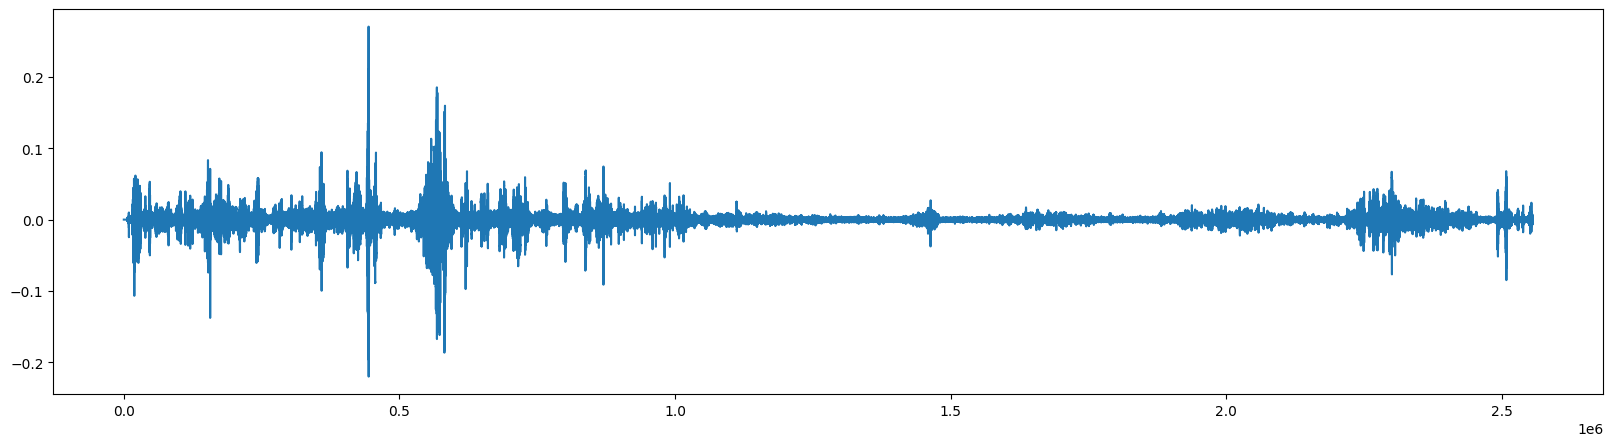

In [56]:
pd.Series(y).plot(figsize=(20, 5))

<Axes: >

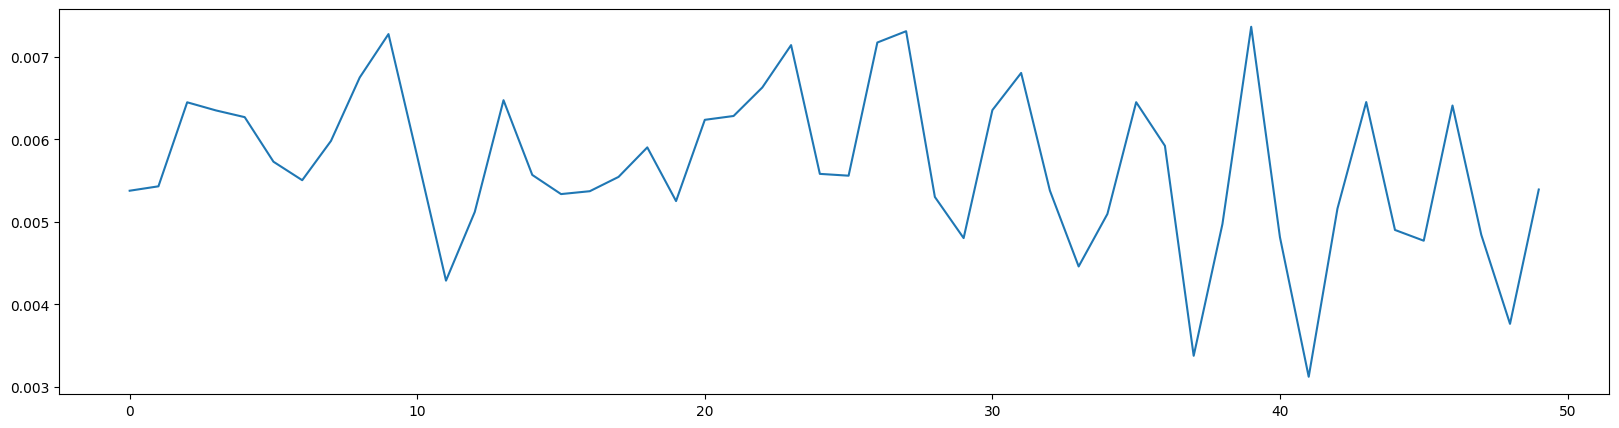

In [55]:
pd.Series(y[55000:55050]).plot(figsize=(20, 5))

### Forier transform on the data to get the frequencies (spectogram)

In [45]:
D = librosa.stft(y)

S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

S_db.shape

(1025, 4993)

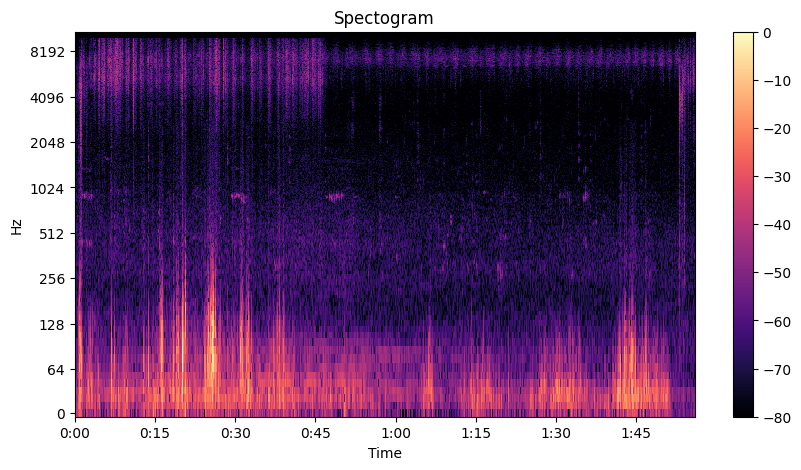

In [ ]:
# plot transformed data
fig, ax = plt.subplots(figsize=(20, 5))
img = librosa.display.specshow(S_db, x_axis="time", y_axis='log', ax=ax)
ax.set_title("Spectogram")
fig.colorbar(img, ax=ax)

### MELL spectogram

In [51]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)

S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

S_db.shape

(128, 4993)

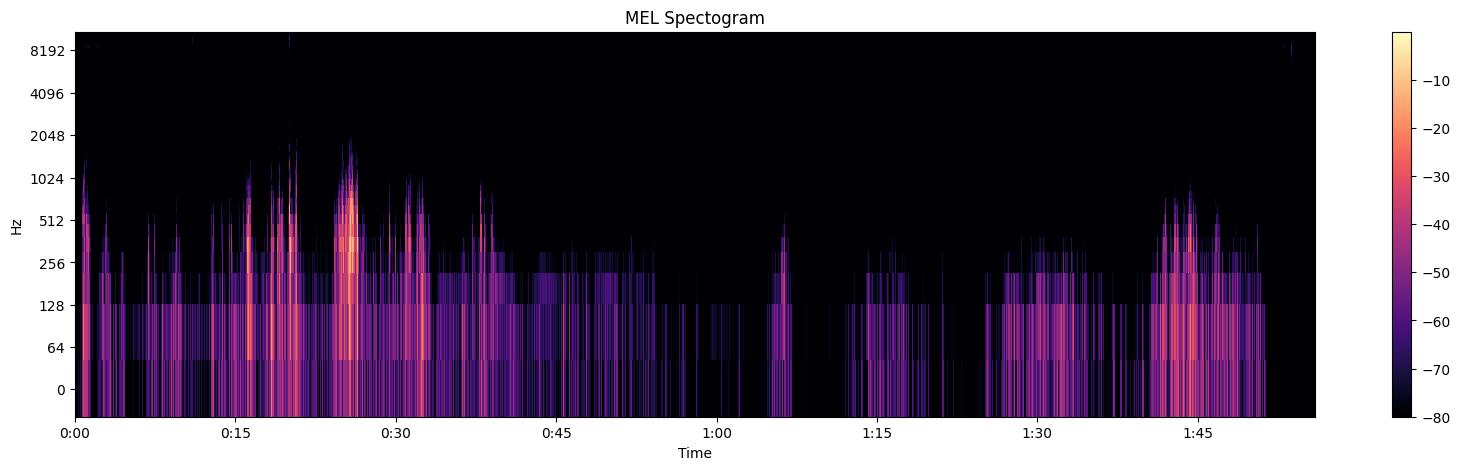

In [54]:
# plot transformed data
fig, ax = plt.subplots(figsize=(20, 5))
img = librosa.display.specshow(S_db, x_axis="time", y_axis='log', ax=ax)
ax.set_title("MEL Spectogram")
fig.colorbar(img, ax=ax)